In [4]:
import sys
sys.path.append('./src')
import torch
from src.model_config import ModelConfig, model_collections
from src.bio_utils import seqlogo_from_msa
from src.data_storage import random_mutant_dataset, virus_seqs
import data
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import save_fig, defaultStyle
import os
from pathlib import Path
import seaborn as sns
import logomaker as lm
from scipy.stats import pearsonr, mode
from math import sqrt, floor, ceil
from tqdm import tqdm
from collections import Counter
defaultStyle()

virus_name = "VEE"
date = "0816"
model_name = "deepcnn"
train_size = 14004

# Import models

In [6]:
# Define the model
mconf = ModelConfig(model_name)
model = model_collections[model_name](mconf)

# Load the model
model_param_files = os.listdir("../models")
param_file_prefix = f"{virus_name}.{date}.{model_name}.params.train.{train_size}"
print(param_file_prefix)
full_param = [f for f in model_param_files if len(f.split('.')) == 6][0]
activation = {}

# Hook function
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Load data 
model.load_state_dict(torch.load(Path('../models') / param_file_prefix))
model.eval()
print(model)

VEE.0816.deepcnn.params.train.14004
DeepCNN(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(4, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (conv1): Sequential(
    (0): Conv1d(4, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)


# Motifs

## Extract all motifs

In [7]:
# Import test set
import pandas as pd
test_path = f"./data/{virus_name}_{date}_test.csv"
data_size = len(pd.read_csv(test_path))
test_data = data.NormalDataset(test_path)
loader = DataLoader(test_data, batch_size=data_size)
filter_sizes = ModelConfig(model_name).conv_filter_sizes
retrieve_layer = "conv1" 
if retrieve_layer == "conv1":
    model.conv1.register_forward_hook(get_activation("conv1"))
    filter_size = filter_sizes[0]
elif retrieve_layer == "conv2":
    model.conv2.register_forward_hook(get_activation("conv2"))
    filter_size = filter_sizes[1] # + filter_sizes[0] // 2
elif retrieve_layer == "conv3":
    model.conv3.register_forward_hook(get_activation("conv3"))
    filter_size = filter_sizes[2] # + filter_sizes[1] // 2
    # filter_size = 13

# Forward the test set
with torch.no_grad():
    for batch in loader:
        out, loss = model(*batch)

first_layer_output = activation[retrieve_layer].data.numpy()

# Find maximal activation
max_activation_val = first_layer_output.max()


# Input data
X = batch[0].cpu().numpy()
y = batch[1].cpu().numpy()
kernel_scores = np.array([
    pearsonr(np.max(first_layer_output[:, i, :], axis=1), y)[0]
     for i in range(first_layer_output.shape[1])
])

# Traverse every kernel
kernel_data_dict = []

bg_seqs = random_mutant_dataset(virus_name).seqs

def generate_positional_counts_mat(seqs, centers, filter_size):
    seqs = bg_seqs
    counts_df_group = []
    center_dict = dict(Counter(centers))
    for i in range(filter_size):
        nt_counts_all = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
        for center in center_dict.keys():
            nt_counts = dict(Counter([s[center - filter_size // 2 + i] for s in seqs]))
            for nt in nt_counts_all.keys():
                nt_counts_all[nt] += nt_counts[nt] * center_dict[center]
        counts_df_group.append(pd.DataFrame.from_records([nt_counts_all]))
    counts_df = pd.concat(counts_df_group).reset_index(drop=True)
    return counts_df

for i in tqdm(range(first_layer_output.shape[1])):
    kernel_output = first_layer_output[:, i, :]
    max_val_locations = np.array(
        [np.argmax(kernel_output[j, :]) for j in range(kernel_output.shape[0])]
    )
    max_activation_vals = np.max(kernel_output, axis=1)
    # print(max_activation_vals)

    # Only focus on the sequences which result in activation of 0.7 * maximum
    indices = np.where(max_activation_vals > 0.0 * max_activation_val)[0]

    # Convert embeddings back to sequences
    seqs = [''.join([test_data.corpus[i] for i in X[idx, :]]) for idx in range(X.shape[0])]
    motifs = []
    centers = []
    for j, center in enumerate(max_val_locations[indices]):
        if center >= filter_size // 2 and center < len(seqs[0]) - filter_size // 2 - 1:
            motif = seqs[j][center - filter_size // 2 : center + filter_size // 2 + 1]
            motifs.append(motif)
            centers.append(center)

    if len(motifs) < 50:
        continue
    
    bg_counts_df = generate_positional_counts_mat(bg_seqs, centers, filter_size)
    # bg_counts_df = bg_counts_df[['A', 'C', 'G', 'T']]
    
    # print(centers)
    counts_df = seqlogo_from_msa(motifs, bg_counts_mat=bg_counts_df) 
    kernel_data_dict.append((counts_df, i, kernel_scores[i], mode(centers)[0], len(motifs)))
    # kernel_data_dict.append((bg_counts_df, i, kernel_scores[i], mode(centers)[0], len(motifs)))
    
    # print(mode(centers)[0])

# sort motif on location 
def takeSecond(elem):
    return elem[3]
kernel_data_dict.sort(key=takeSecond)
print(kernel_data_dict)


/home/dell/anaconda3/envs/utr/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 128/128 [01:54<00:00,  1.12it/s]

[(          A         C         G         T
0  0.323450  0.081901  0.008903  0.005342
1  0.046300  0.265171  0.043144  0.389339
2  0.124198  0.694452  0.395331  0.022741
3  0.043217  0.003705  0.356843  0.469205
4  0.053000  0.050350  0.214647  0.150386, 94, -0.2603727387643034, array([2]), 707), (          A         C         G         T
0  0.043815  0.014607  0.014607  2.552066
1  0.011340  0.253989  1.210976  0.154208
2  0.316927  0.108284  0.485955  0.038296
3  0.009780  0.019558  1.532687  0.195560
4  0.355368  1.646224  0.145793  0.036450, 78, -0.19850994451074316, array([3]), 719), (          A         C         G         T
0  0.049390  0.000001  0.278040  0.954843
1  0.164554  0.003382  0.429417  0.192731
2  0.063502  0.034194  1.365256  0.249118
3  0.011124  0.415258  0.839783  0.033370
4  0.352055  0.282096  0.147818  0.009028, 95, -0.12900201745991896, array([3]), 701), (          A             C         G         T
0  0.229305  5.197045e-07  0.199948  0.090453
1  0.412748  

/home/dell/anaconda3/envs/utr/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Saving figure deepcnn_conv3ac0_motifs_loca_13bp


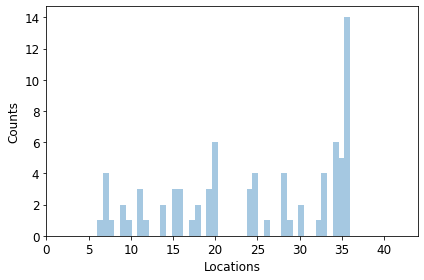

In [6]:
loca = pd.DataFrame(np.random.randint(0, 100, size=(len(kernel_data_dict), 1)))
for i in range(len(kernel_data_dict)):
    loca.iloc[i, 0] = kernel_data_dict[i][3]
# print(loca.iloc[:,0])
sns.distplot(loca.iloc[:,0],kde=False,bins=44)
plt.xlim((0,44))
plt.xlabel('Locations')
plt.ylabel('Counts')
# save_fig("deepcnn_conv3ac0_motifs_loca_13bp")


In [20]:
print(len(kernel_data_dict))

50


## motif similarity by TOMTOM

In [9]:
import numpy as np
import subprocess
from pathlib import Path

with open ("/home/dell/Documents/202205-rdrpEvolu/Alphavirus_5-UTR-master/data/motif/220412/cnn-motif-conv3ac0.meme", "w") as f:
    f.writelines("MEME version 5.4.1 (Tue Mar 1 19:18:48 2022 -0800)"+"\n")
    f.writelines("\n")
    f.writelines("ALPHABET= ACGT"+"\n")
    f.writelines("\n")
    f.writelines("Background letter frequencies (from uniform background):"+"\n")
    f.writelines("A 0.25000 C 0.25000 G 0.25000 T 0.25000 "+"\n")
    f.writelines("\n")
    for i in range(len(kernel_data_dict)):
        # print(i)
        # print(kernel_data_dict[i][1])
        f.writelines("MOTIF "+str(i)+" "+str(i)+"\n")
        f.writelines("\n")
        f.writelines("letter-probability matrix: alength= 4 w= 12 nsites= 20 E= 0"+"\n") #you want to change the width
        for index in range(len(kernel_data_dict[0][0])):
            sum = kernel_data_dict[i][0].apply(lambda x:x.sum(),axis =1)
            f.writelines(str(kernel_data_dict[i][0].iloc[index,0]/sum[index])+" "+str(kernel_data_dict[i][0].iloc[index,1]/sum[index])+" "+str(kernel_data_dict[i][0].iloc[index,2]/sum[index])+" "+str(kernel_data_dict[i][0].iloc[index,3]/sum[index])+" "+"\n")
        f.writelines("\n")

for i in range(len(kernel_data_dict)):
    with open ("/home/dell/Documents/202205-rdrpEvolu/Alphavirus_5-UTR-master/data/motif/220412/cnn-motif-conv3ac0-%s.meme" % (i), "w") as f:
        f.writelines("MEME version 5.4.1 (Tue Mar 1 19:18:48 2022 -0800)"+"\n")
        f.writelines("\n")
        f.writelines("ALPHABET= ACGT"+"\n")
        f.writelines("\n")
        f.writelines("Background letter frequencies (from uniform background):"+"\n")
        f.writelines("A 0.25000 C 0.25000 G 0.25000 T 0.25000 "+"\n")
        f.writelines("\n")
        f.writelines("MOTIF "+str(i)+" "+str(i)+"\n")
        f.writelines("\n")
        f.writelines("letter-probability matrix: alength= 4 w= 12 nsites= 20 E= 0"+"\n") #you want to change the width
        for index in range(len(kernel_data_dict[0][0])):
            sum = kernel_data_dict[i][0].apply(lambda x:x.sum(),axis =1)
            f.writelines(str(kernel_data_dict[i][0].iloc[index,0]/sum[index])+" "+str(kernel_data_dict[i][0].iloc[index,1]/sum[index])+" "+str(kernel_data_dict[i][0].iloc[index,2]/sum[index])+" "+str(kernel_data_dict[i][0].iloc[index,3]/sum[index])+" "+"\n")
        f.writelines("\n")
    
    result_path = Path("/home/dell/Documents/202205-rdrpEvolu/Alphavirus_5-UTR-master/data/motif/220412")
    result_path_pattern = "cnn-motif-conv3ac0-TOM-%s/" % (i)
    input_path_pattern = "cnn-motif-conv3ac0-%s.meme" % (i)
    result_path_fin = result_path / result_path_pattern
    input_path_fin = result_path / input_path_pattern

    subprocess.run(
            f''' 
            export PATH=/usr/local/bin/meme/bin:/usr/local/bin/meme/libexec/meme-5.4.1:$PATH
            tomtom -no-ssc -oc {result_path_fin} \
            -verbosity 1 \
            -min-overlap 5 \
            -dist pearson \
            -evalue \
            -thresh 100000.0 \
            -norc \
            {input_path_fin} \
            /home/dell/Documents/202205-rdrpEvolu/Alphavirus_5-UTR-master/data/motif/220412/cnn-motif-conv3ac0.meme
            ''',
            shell=True
        )


In [10]:
simi_matrix = pd.DataFrame()
import math
# for i in range(116):
for i in range(len(kernel_data_dict)):
    
    result_path = Path("/home/dell/Documents/202205-rdrpEvolu/Alphavirus_5-UTR-master/data/motif/220412")
    result_path_pattern = "cnn-motif-conv3ac0-TOM-%s/" % (i)
    input_path_pattern = "cnn-motif-conv3ac0-%s.meme" % (i)
    result_path_fin = result_path / result_path_pattern
    input_path_fin = result_path / input_path_pattern
    data=pd.read_csv(result_path_fin/'tomtom.tsv',sep='\t')
    data = data.drop(data.tail(3).index)
    # data['simi'] = data['p-value'].apply(lambda x: math.log(1/x))
    data['simi'] = data['p-value']
    data = data.sort_values(by='Target_ID',axis=0)
    data = {"simi": pd.Series(data["simi"].values)}
    new_df = pd.DataFrame(data)

    # data.sort_values(by="Target_ID" , inplace=True, ascending=True)
    simi_matrix['%s' % (i)] = new_df['simi']

simi_matrix_fin = simi_matrix.copy()
for i in range(len(simi_matrix)):
    for j in range(len(simi_matrix)):
        simi_matrix_fin.iloc[i,j]=simi_matrix.iloc[i,j]+simi_matrix.iloc[j,i]

print(simi_matrix_fin)

               0             1             2             3             4  \
0   4.819700e-25  5.863840e-04  6.936520e-06  2.363984e-03  1.324471e-03   
1   5.863840e-04  2.862520e-25  2.525858e-03  4.929426e-04  5.294320e-02   
2   6.936520e-06  2.525858e-03  5.918160e-19  4.463310e-05  3.789464e-02   
3   2.363984e-03  4.929426e-04  4.463310e-05  1.717510e-23  4.342989e-02   
4   1.324471e-03  5.294320e-02  3.789464e-02  4.342989e-02  2.782060e-25   
..           ...           ...           ...           ...           ...   
73  7.618350e-02  7.235950e-01  6.516620e-02  1.934685e-01  1.174411e+00   
74  8.967710e-01  1.526103e+00  7.476070e-01  1.995006e+00  1.786031e+00   
75  1.053635e+00  1.570830e+00  8.765760e-01  1.995969e+00  1.810695e+00   
76  1.758739e+00  1.893646e+00  1.450675e+00  1.999722e+00  1.909095e+00   
77  1.594310e+00  1.732392e+00  1.344962e+00  1.999771e+00  1.921779e+00   

           5         6         7         8         9  ...            68  \
0   0.000240

/tmp/ipykernel_4144/4002462770.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  simi_matrix_fin.values[[np.arange(simi_matrix_fin.shape[0])]*2] = 1


Saving figure deepcnn_conv3ac0_12bp_motifs_simi


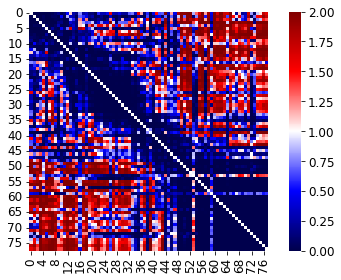

In [12]:
simi_matrix_fin.values[[np.arange(simi_matrix_fin.shape[0])]*2] = 1
sns.heatmap(simi_matrix_fin, cmap='seismic',square=True)
save_fig('deepcnn_conv3ac0_12bp_motifs_simi')
# ax2.axis('off')

In [15]:
simi_matrix = pd.DataFrame()
import math
for i in range(127):
# for i in range(len(kernel_data_dict)):
    
    result_path = Path("../data/motif/220412/TOM-cnn-motif-conv1")
    # result_path_pattern = "cnn-motif-conv3ac0-TOM-%s/" % (i)
    # input_path_pattern = "cnn-motif-conv3ac0-%s.meme" % (i)
    # result_path_fin = result_path / result_path_pattern
    # input_path_fin = result_path / input_path_pattern
    data=pd.read_csv(result_path/'tomtom.tsv',sep='\t')
    data = data.drop(data.tail(3).index)
    # data['simi'] = data['p-value'].apply(lambda x: math.log(1/x))
    data['simi'] = data['p-value']
    data = data.sort_values(by='Target_ID',axis=0)
    data = {"simi": pd.Series(data["simi"].values)}
    new_df = pd.DataFrame(data)

# data.sort_values(by="Target_ID" , inplace=True, ascending=True)
    simi_matrix['%s' % (i)] = new_df['simi']

simi_matrix_fin = simi_matrix.copy()
print(simi_matrix)
for i in range(len(simi_matrix)):
    for j in range(len(simi_matrix)):
        simi_matrix_fin.iloc[i,j]=simi_matrix.iloc[i,j]+simi_matrix.iloc[j,i]


                126
0      5.369760e-11
1      5.701650e-01
2      3.781380e-01
3      8.309030e-02
4      3.636850e-01
...             ...
16124  7.866380e-01
16125  7.362660e-01
16126  4.320210e-01
16127  9.974280e-01
16128  1.000370e-01

[16129 rows x 1 columns]


IndexError: index 1 is out of bounds for axis 0 with size 1

## Draw all motifs

/home/dell/anaconda3/envs/utr/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/dell/anaconda3/envs/utr/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/dell/anaconda3/envs/utr/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/dell/anaconda3/envs/utr/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/dell/anaconda3/envs/utr/lib/python3.8/site-packages/sc

Saving figure deepcnn_conv3_motifs


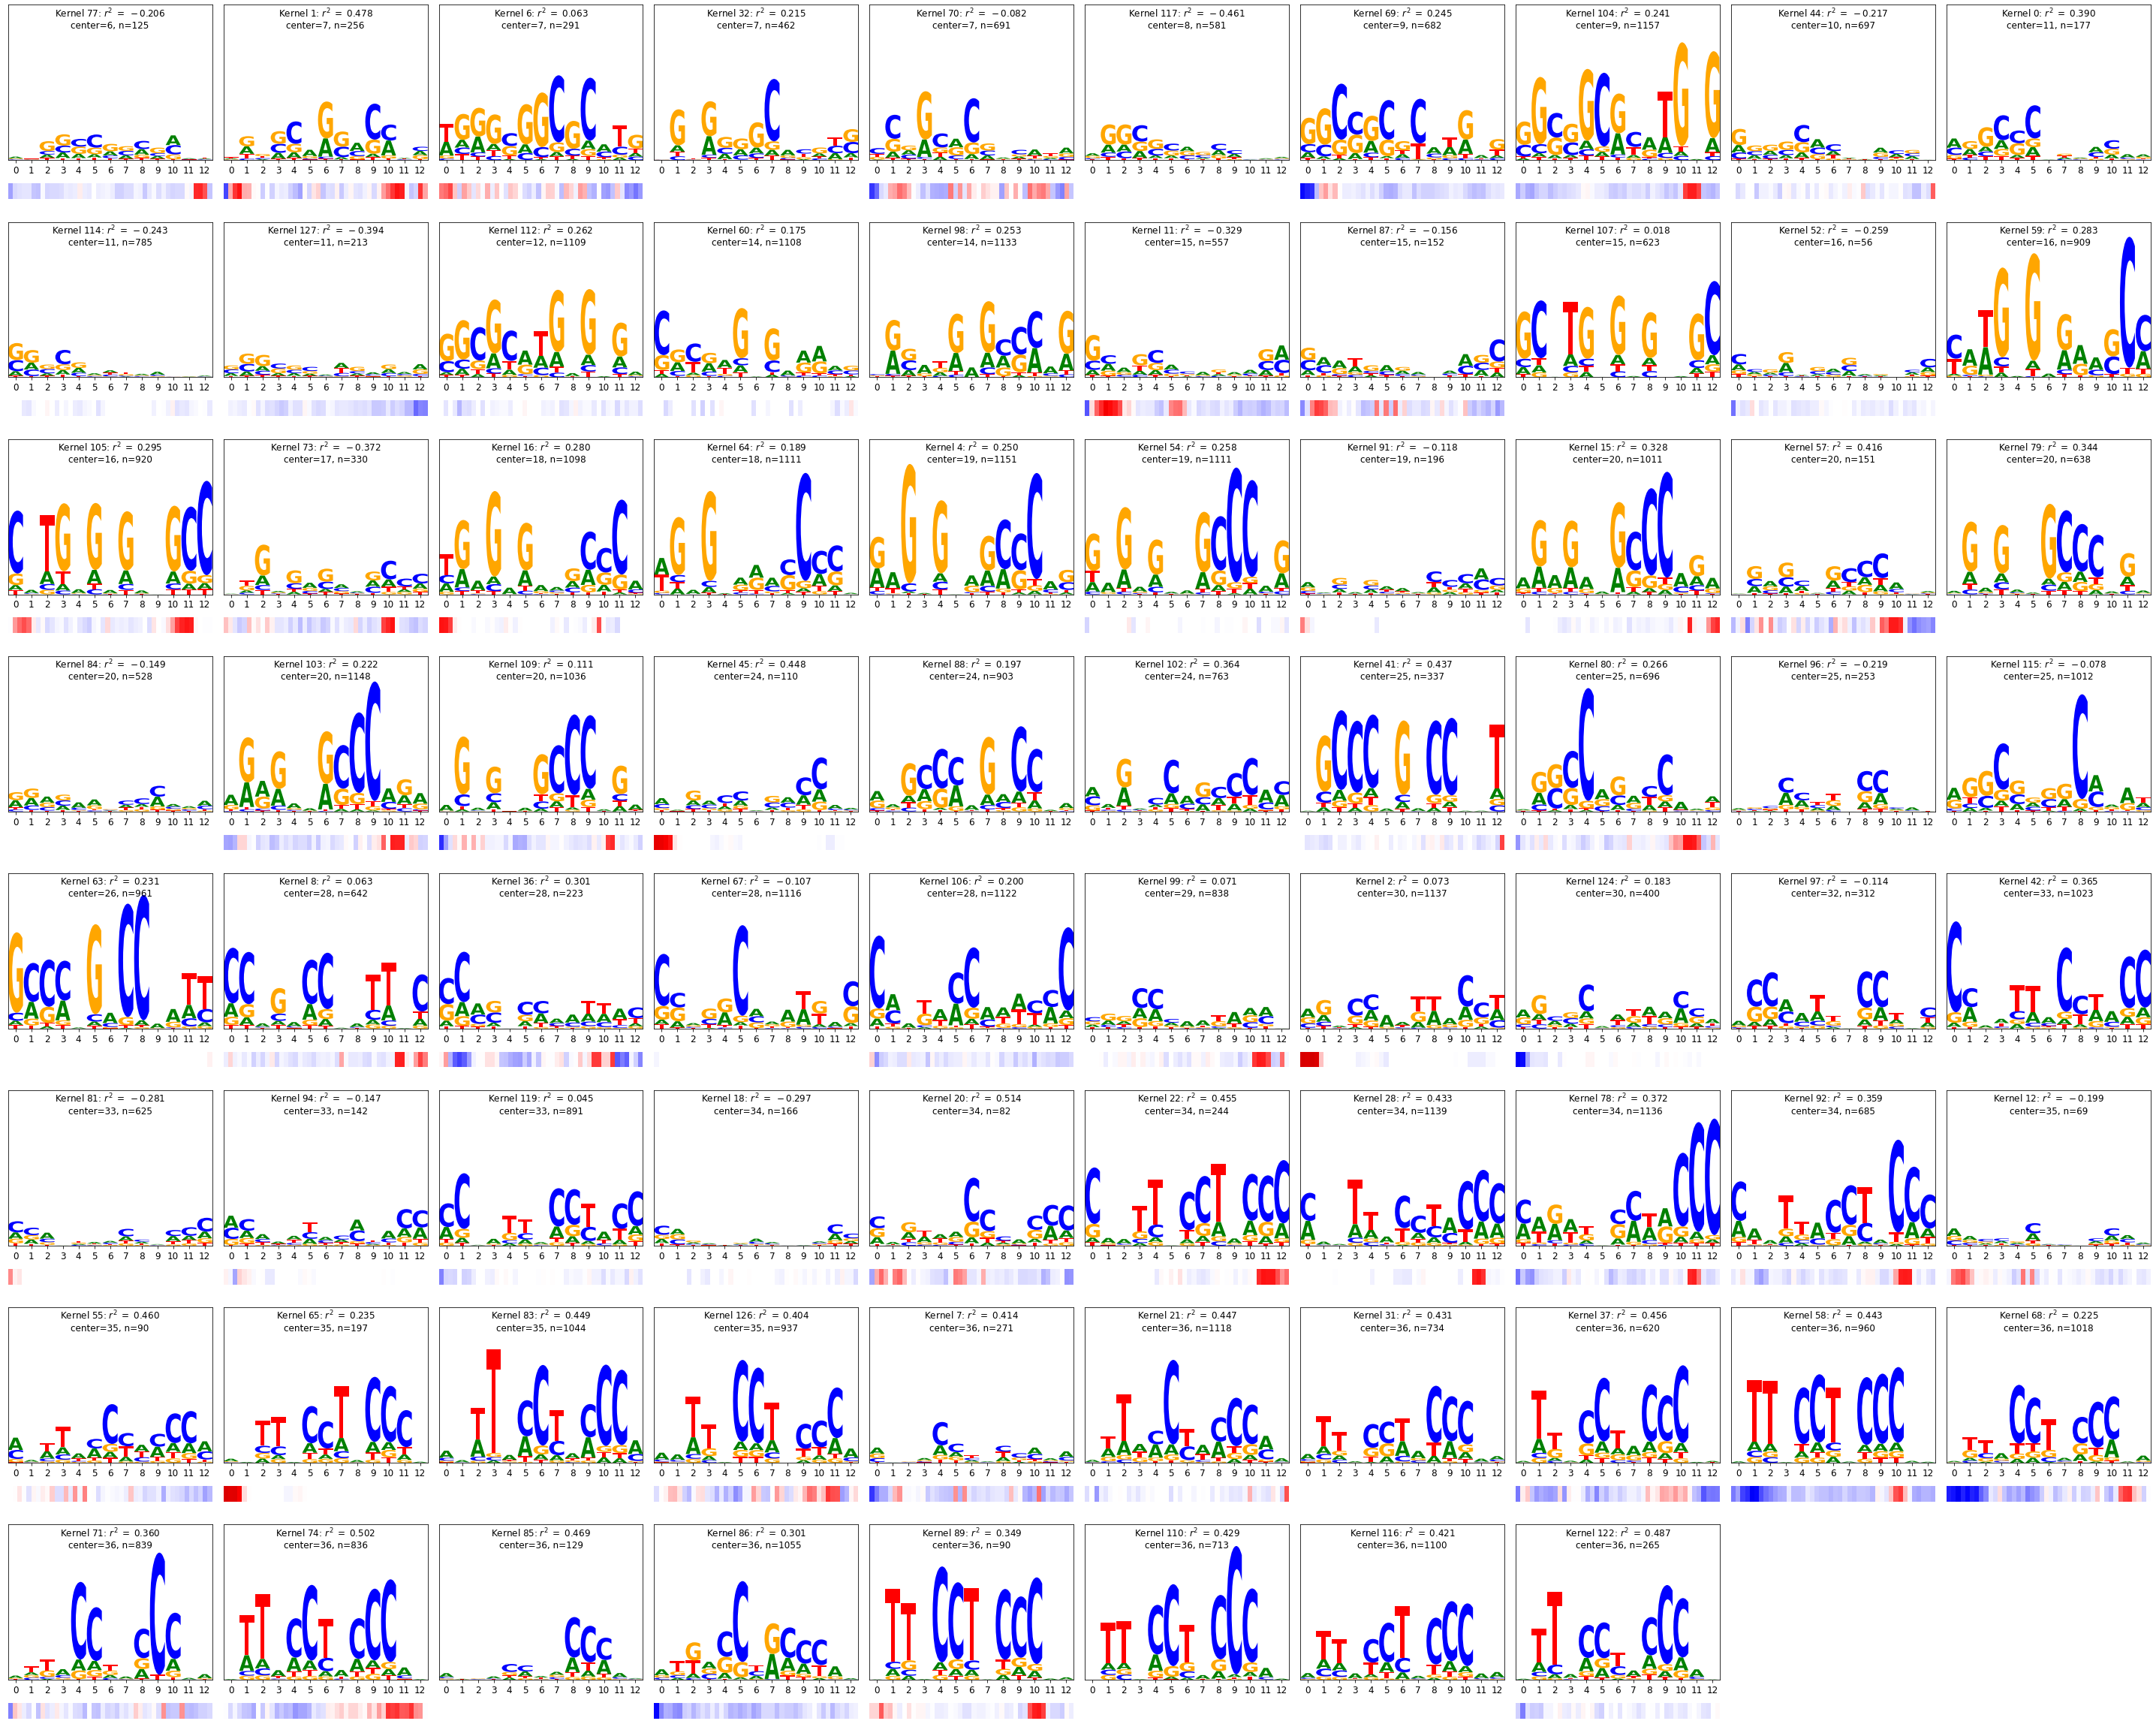

In [12]:
n_kernel = len(kernel_data_dict)
row = floor(sqrt(n_kernel))
col = ceil(n_kernel / row)

fig = plt.figure(figsize=(col * 4, row * 4))
gs = plt.GridSpec(row * 2, col, figure=fig, height_ratios=[10, 1] * row)

for i, (counts_df, kernel_idx, kernel_score, kernel_loc, n_motifs) in enumerate(kernel_data_dict[:n_kernel]):
    ax = fig.add_subplot(gs[i // col * 2, i % col])
    lm.Logo(counts_df, ax=ax, color_scheme="classic")
    ax.set_ylim([0, 4])
    ax.set_xticks(list(range(filter_size)))
    ax.text(
        filter_size // 2, 3.96, 
        f"Kernel %d: $r^2\;=\;%.3f$\ncenter=%d, n=%d"%(kernel_idx, kernel_score, kernel_loc, n_motifs),
        ha='center', va='top', fontsize=12
    )
    ax.set_yticks([])
    ax2 = fig.add_subplot(gs[i // col * 2 + 1, i % col])
    kernel_score_dist = np.array([
        pearsonr(first_layer_output[:, i, loc], y)[0]
        for loc in range(first_layer_output.shape[2])
    ])
    sns.heatmap(kernel_score_dist.reshape((1, -1)), ax=ax2, cmap='seismic', vmin=-1, vmax=1, cbar=False)
    ax2.axis('off')
save_fig('deepcnn_conv3_motifs')

# Saliency map

[Text(0, 0.5, 'A'), Text(0, 1.5, 'T'), Text(0, 2.5, 'C'), Text(0, 3.5, 'G')]

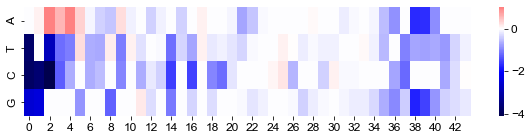

In [21]:
def predict_seq_score(seq):
    X = torch.tensor([test_data.tok2idx[s] for s in seq]).unsqueeze(0)
    original_score, _ = model(X)
    original_score = original_score.detach().numpy()
    return original_score[0]

original_seq = virus_seqs(virus_name).original_seq
original_score = predict_seq_score(original_seq)
saliency_arr = np.zeros((4, len(original_seq)))

for i in range(len(original_seq)):
    for j, nt in enumerate(['A', 'T', 'C', 'G']):
        saliency_arr[j, i] = predict_seq_score(original_seq[:i] + nt + original_seq[i+1:])
saliency_arr -= original_score

_, ax = plt.subplots(1, 1, figsize=(10, 2))
sns.heatmap(saliency_arr, cmap='seismic', center=0)
ax.set_yticks(np.arange(4) + 0.5)
ax.set_yticklabels(['A', 'T', 'C', 'G'])